In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "input"]).decode("utf8"))

RegularSeasonCompactResults.csv
RegularSeasonDetailedResults.csv
SampleSubmission.csv
Seasons.csv
Teams.csv
TourneyCompactResults.csv
TourneyDetailedResults.csv
TourneySeeds.csv
TourneySlots.csv



In [2]:
data_dir = 'input/'
df_seeds = pd.read_csv(data_dir + 'TourneySeeds.csv')
df_tour = pd.read_csv(data_dir + 'TourneyCompactResults.csv')
# df_seeds.head()
# df_tour.head()

In [3]:
#Remove unimportant data columns for seed generation
df_tour.drop(labels=['Daynum', 'Wscore', 'Lscore', 'Wloc', 'Numot'], inplace=True, axis=1)
df_tour.head()

,Season,Wteam,Lteam
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


In [4]:
#Get seeds
def seed_to_int(seed):
    """Get just the digits from the seeding. Return as int"""
    s_int = int(seed[1:3])
    return s_int
df_seeds['n_seed'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label

In [5]:
df_seeds.head()

,Season,Team,n_seed
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


In [6]:
df_reg_stats = pd.read_csv(data_dir + 'RegularSeasonDetailedResults.csv')
df_reg_stats.head()

#df_reg_stats.shape
#76636 Games Total

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [7]:
# Remove useless data columns for stat calculations (Date, Location, Number of Overtimes)
df_reg_stats.drop(labels=['Daynum', 'Wloc', 'Numot'], inplace=True, axis=1)


In [8]:
## UNC Stats
#df.loc[df['column_name'] == some_value]
#new1 = df_reg_stats.loc[df_reg_stats['Season'] == 2017]
#new2 = new1.loc[new1['Wteam'] == 1314]
#new2.shape

In [9]:
#### Calculate statistics for each team from 2003-2017 and store in a large dictionary

seasons_dict = {}
team_dict = {}
for index, row in df_reg_stats.iterrows():
    if row[0] in seasons_dict.keys():
        for x in [1,3]:
            if x == 1:
                if row[x] in seasons_dict[row[0]].keys():

                    seasons_dict[row[0]][row[1]]['Games'] += 1
                    seasons_dict[row[0]][row[1]]['Wins'] += 1
                    seasons_dict[row[0]][row[1]]['Losses'] += 0
                    seasons_dict[row[0]][row[1]]['Points'] += row[2]
                    seasons_dict[row[0]][row[1]]['FGM'] += row[5]
                    seasons_dict[row[0]][row[1]]['FGA'] += row[6]
                    seasons_dict[row[0]][row[1]]['3PM'] += row[7]
                    seasons_dict[row[0]][row[1]]['3PA'] += row[8]
                    seasons_dict[row[0]][row[1]]['FTM'] += row[9]
                    seasons_dict[row[0]][row[1]]['FTA'] += row[10]
                    seasons_dict[row[0]][row[1]]['O_Reb'] += row[11]
                    seasons_dict[row[0]][row[1]]['D_Reb'] += row[12]
                    seasons_dict[row[0]][row[1]]['Ast'] += row[13]
                    seasons_dict[row[0]][row[1]]['TO'] += row[14]
                    seasons_dict[row[0]][row[1]]['Stl'] += row[15]
                    seasons_dict[row[0]][row[1]]['Blk'] += row[16]
                    seasons_dict[row[0]][row[1]]['PF'] += row[17]

                elif row[1] not in seasons_dict[row[0]].keys():
                    seasons_dict[row[0]][row[1]] = {'Games': 1, 'Wins':1, 'Losses':0, 'Points': row[2], 'FGM': row[5], 'FGA': row[6], \
                                                  '3PM': row[7], '3PA': row[8], 'FTM': row[9], 'FTA': row[10],\
                                                  'O_Reb': row[11], 'D_Reb': row[12], 'Ast': row[13], 'TO': row[14], \
                                                  'Stl': row[15], 'Blk': row[16], 'PF': row[17]}
            else:
                if row[3] in seasons_dict[row[0]].keys():
                    seasons_dict[row[0]][row[3]]['Games'] += 1
                    seasons_dict[row[0]][row[3]]['Wins'] += 0
                    seasons_dict[row[0]][row[3]]['Losses'] += 1
                    seasons_dict[row[0]][row[3]]['Points'] += row[4]
                    seasons_dict[row[0]][row[3]]['FGM'] += row[18]
                    seasons_dict[row[0]][row[3]]['FGA'] += row[19]
                    seasons_dict[row[0]][row[3]]['3PM'] += row[20]
                    seasons_dict[row[0]][row[3]]['3PA'] += row[21]
                    seasons_dict[row[0]][row[3]]['FTM'] += row[22]
                    seasons_dict[row[0]][row[3]]['FTA'] += row[23]
                    seasons_dict[row[0]][row[3]]['O_Reb'] += row[24]
                    seasons_dict[row[0]][row[3]]['D_Reb'] += row[25]
                    seasons_dict[row[0]][row[3]]['Ast'] += row[26]
                    seasons_dict[row[0]][row[3]]['TO'] += row[27]
                    seasons_dict[row[0]][row[3]]['Stl'] += row[28]
                    seasons_dict[row[0]][row[3]]['Blk'] += row[29]
                    seasons_dict[row[0]][row[3]]['PF'] += row[30]
                
                    
                elif row[3] not in seasons_dict[row[0]].keys():
                    seasons_dict[row[0]][row[3]] = {'Games': 1,'Wins':0, 'Losses':1, 'Points': row[4], 'FGM': row[18], 'FGA': row[19], \
                                                  '3PM': row[20], '3PA': row[21], 'FTM': row[22], 'FTA': row[23],\
                                                  'O_Reb': row[24], 'D_Reb': row[25], 'Ast': row[26], 'TO': row[27], \
                                                  'Stl': row[28], 'Blk': row[29], 'PF': row[30]}


    else:
        seasons_dict[row[0]] = {row[1]: {'Games': 1, 'Wins':1, 'Losses':0, 'Points': row[2], 'FGM': row[5], 'FGA': row[6], \
                                          '3PM': row[7], '3PA': row[8], 'FTM': row[9], 'FTA': row[10],\
                                          'O_Reb': row[11], 'D_Reb': row[12], 'Ast': row[13], 'TO': row[14], \
                                          'Stl': row[15], 'Blk': row[16], 'PF': row[17]}, \
                                row[3]: {'Games': 1, 'Wins':0, 'Losses':1, 'Points': row[4], 'FGM': row[18], 'FGA': row[19], \
                                          '3PM': row[20], '3PA': row[21], 'FTM': row[22], 'FTA': row[23],\
                                          'O_Reb': row[24], 'D_Reb': row[25], 'Ast': row[26], 'TO': row[27], \
                                          'Stl': row[28], 'Blk': row[29], 'PF': row[30]}}


In [10]:
### Calculate per game statistics

for yr in seasons_dict:
    for team in seasons_dict[yr]:
        seasons_dict[yr][team]['FT_perc'] = (seasons_dict[yr][team]['FTM']) / seasons_dict[yr][team]['FTA']
        seasons_dict[yr][team]['FG_perc'] = (seasons_dict[yr][team]['FGM']) / seasons_dict[yr][team]['FGA']
        seasons_dict[yr][team]['3P_perc'] = (seasons_dict[yr][team]['3PM']) / seasons_dict[yr][team]['3PA']
        for cat in seasons_dict[yr][team]:
            if cat not in ['Games', 'Wins', 'Losses', 'FT_perc', 'FG_perc', '3P_perc']:
                seasons_dict[yr][team][cat] = (seasons_dict[yr][team][cat]) / seasons_dict[yr][team]['Games']

#North Carolina - 2017
print(seasons_dict[2017][1314])
    

{'Games': 33, 'Wins': 26, 'Losses': 7, 'Points': 84.333333333333329, 'FGM': 30.848484848484848, 'FGA': 65.909090909090907, '3PM': 7.2424242424242422, '3PA': 19.757575757575758, 'FTM': 15.393939393939394, 'FTA': 21.787878787878789, 'O_Reb': 15.757575757575758, 'D_Reb': 27.484848484848484, 'Ast': 18.212121212121211, 'TO': 11.878787878787879, 'Stl': 6.7878787878787881, 'Blk': 3.2121212121212119, 'PF': 17.90909090909091, 'FT_perc': 0.70653685674547984, 'FG_perc': 0.46804597701149425, '3P_perc': 0.3665644171779141}


In [11]:
#Keys for each dictionary -- years, statistical categories

print(seasons_dict.keys())
print(seasons_dict[2005][1314].keys())

dict_keys([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])
dict_keys(['Games', 'Wins', 'Losses', 'Points', 'FGM', 'FGA', '3PM', '3PA', 'FTM', 'FTA', 'O_Reb', 'D_Reb', 'Ast', 'TO', 'Stl', 'Blk', 'PF', 'FT_perc', 'FG_perc', '3P_perc'])


In [12]:
## Write a data file for each team's historical statistical data

def write_data_file(data_dict):
    output_file = 'season_stats_computed.csv'
    #This is lazy -- 
    years = [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
    header = 'Year,TeamID,Games,Wins,Losses,Points,FGM,FGA,FG_Perc,3PM,3PA,3P_perc,FTM,FTA,FT_perc,O_Reb,D_Reb,Ast,TO,Stl,Blk,PF\n'
    with open(output_file, 'w') as ofile:
        ofile.write(header)
        for year in years:
            for team in data_dict[year].keys():
                team_stat_str = '%d,%d,%d,%d,%d,%d,%d,%d,%f,%d,%d,%f,%d,%d,%f,%d,%d,%d,%d,%d,%d,%d\n' % \
                (year, team, data_dict[year][team]['Games'], data_dict[year][team]['Wins'], \
                 data_dict[year][team]['Losses'], data_dict[year][team]['Points'], \
                 data_dict[year][team]['FGM'], data_dict[year][team]['FGA'], data_dict[year][team]['FG_perc'],\
                 data_dict[year][team]['3PM'], data_dict[year][team]['3PA'], data_dict[year][team]['3P_perc'],\
                 data_dict[year][team]['FTM'], data_dict[year][team]['FTA'], data_dict[year][team]['FT_perc'],\
                 data_dict[year][team]['O_Reb'], data_dict[year][team]['D_Reb'], \
                 data_dict[year][team]['Ast'], data_dict[year][team]['TO'], \
                 data_dict[year][team]['Stl'], data_dict[year][team]['Blk'], \
                 data_dict[year][team]['PF'])
                 
                ofile.write(team_stat_str)
    ofile.close()
    

write_data_file(seasons_dict)
                
        

In [13]:
#
df_winseeds = df_seeds.rename(columns={'Team':'Wteam', 'n_seed':'win_seed'})
df_lossseeds = df_seeds.rename(columns={'Team':'Lteam', 'n_seed':'loss_seed'})

df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'Wteam'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'Lteam'])
df_concat['seed_diff'] = df_concat.win_seed - df_concat.loss_seed
df_concat.shape

(2050, 6)

In [14]:
df_concat.head()

,Season,Wteam,Lteam,win_seed,loss_seed,seed_diff
0,1985,1116,1234,9,8,1
1,1985,1120,1345,11,6,5
2,1985,1207,1250,1,16,-15
3,1985,1229,1425,9,8,1
4,1985,1242,1325,3,14,-11


In [15]:
# Grab regular season data from 2003 onward 
df_concat_with_regseason_stats = df_concat.copy()
df_new_concat_stats = df_concat_with_regseason_stats[(df_concat_with_regseason_stats['Season'] >= 2003)]
df_new_concat_stats.head()

,Season,Wteam,Lteam,win_seed,loss_seed,seed_diff
1136,2003,1421,1411,16,16,0
1137,2003,1112,1436,1,16,-15
1138,2003,1113,1272,10,7,3
1139,2003,1141,1166,11,6,5
1140,2003,1143,1301,8,9,-1


In [16]:
### This function creates the final data which displays the difference in teams per game stastical 
# categories to be put into our models and used for our machine learning predictions

def write_tourney_matchups_w_regstats(data_dict):
    output_file = 'tourney_stats_diff.csv'
    header = 'Year,W_TeamID,L_TeamID,W_seed,L_seed,seed_diff,Points_diff,FGM_diff,FGA_diff,3PM_diff,3PA_diff,FTM_diff,FTA_diff,FG_perc_diff,3P_perc_diff,ft_perc_diff,o_reb_diff,d_reb_diff,ast_diff,to_diff,stl_diff,blk_diff,pf_diff\n'

    with open(output_file, 'w') as ofile2:
        ofile2.write(header)
        for index, row in df_new_concat_stats.iterrows():
            points_diff = (data_dict[row[0]][row[1]]['Points']) - (data_dict[row[0]][row[2]]['Points'])
            fgm_diff = (data_dict[row[0]][row[1]]['FGM']) - (data_dict[row[0]][row[2]]['FGM'])
            threepm_diff = (data_dict[row[0]][row[1]]['3PM']) - (data_dict[row[0]][row[2]]['3PM'])
            ftm_diff = (data_dict[row[0]][row[1]]['FTM']) - (data_dict[row[0]][row[2]]['FTM'])
            fga_diff = (data_dict[row[0]][row[1]]['FGA']) - (data_dict[row[0]][row[2]]['FGA'])
            threepa_diff = (data_dict[row[0]][row[1]]['3PA']) - (data_dict[row[0]][row[2]]['3PA'])
            fta_diff = (data_dict[row[0]][row[1]]['FTA']) - (data_dict[row[0]][row[2]]['FTA'])
            fg_perc_diff = (data_dict[row[0]][row[1]]['FG_perc']) - (data_dict[row[0]][row[2]]['FG_perc'])
            three_perc_diff = (data_dict[row[0]][row[1]]['3P_perc']) - (data_dict[row[0]][row[2]]['3P_perc'])
            ft_perc_diff = (data_dict[row[0]][row[1]]['FT_perc']) - (data_dict[row[0]][row[2]]['FT_perc'])
            o_reb_diff = (data_dict[row[0]][row[1]]['O_Reb']) - (data_dict[row[0]][row[2]]['O_Reb'])
            d_reb_diff = (data_dict[row[0]][row[1]]['D_Reb']) - (data_dict[row[0]][row[2]]['D_Reb'])
            ast_diff = (data_dict[row[0]][row[1]]['Ast']) - (data_dict[row[0]][row[2]]['Ast'])
            to_diff = (data_dict[row[0]][row[1]]['TO']) - (data_dict[row[0]][row[2]]['TO'])
            stl_diff = (data_dict[row[0]][row[1]]['Stl']) - (data_dict[row[0]][row[2]]['Stl'])
            blk_diff = (data_dict[row[0]][row[1]]['Blk']) - (data_dict[row[0]][row[2]]['Blk'])
            pf_diff = (data_dict[row[0]][row[1]]['PF']) - (data_dict[row[0]][row[2]]['PF'])
            
            output_str = '%d,%d,%d,%d,%d,%d,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f\n' % \
            (row[0], row[1], row[2], row[3], row[4], row[5], points_diff, fgm_diff, fga_diff, threepm_diff, \
             threepa_diff, ftm_diff, fta_diff, fg_perc_diff, three_perc_diff, \
             ft_perc_diff, o_reb_diff, d_reb_diff, ast_diff, to_diff, stl_diff, blk_diff, pf_diff)
            ofile2.write(output_str)
    ofile2.close()

write_tourney_matchups_w_regstats(seasons_dict)

ppg_1 = seasons_dict[2003][1421]['Points'] / seasons_dict[2003][1421]['Games']
ppg_2 = seasons_dict[2003][1411]['Points'] / seasons_dict[2003][1411]['Games']
print(ppg_1 - ppg_2)
print(seasons_dict[2005][1314]['3PM'])
print(seasons_dict[2005][1314]['Points'])



#df_concat_with_regseason_stats.head()

0.0287435592549
7.38709677419
88.7741935484


In [17]:
df_tour_w_regstats = pd.read_csv('tourney_stats_diff.csv')
df_tour_w_regstats.head()


,Year,W_TeamID,L_TeamID,W_seed,L_seed,seed_diff,Points_diff,FGM_diff,FGA_diff,3PM_diff,...,FG_perc_diff,3P_perc_diff,ft_perc_diff,o_reb_diff,d_reb_diff,ast_diff,to_diff,stl_diff,blk_diff,pf_diff
0,2003,1421,1411,16,16,0,-1.593103,-0.354023,1.526437,0.549425,...,-0.018262,0.039433,0.142815,-0.890805,-1.627586,-1.165517,0.973563,0.635632,0.766667,0.803448
1,2003,1112,1436,1,16,-15,17.421182,5.493842,9.852217,1.759852,...,0.016969,0.009777,0.043580,2.213054,1.918719,3.435961,0.716749,1.602217,1.248768,1.853448
2,2003,1113,1272,10,7,3,1.448276,0.931034,-3.103448,-3.000000,...,0.040251,-0.030989,0.016122,-0.379310,-2.655172,-1.068966,0.206897,-2.172414,-0.827586,0.655172
3,2003,1141,1166,11,6,5,0.102403,-2.076280,-4.764890,-1.142111,...,0.005763,-0.008284,0.072864,-0.292581,0.094044,-1.197492,4.877743,-1.290491,-0.454545,3.692790
4,2003,1143,1301,8,9,-1,2.082759,3.011494,5.390805,-1.552874,...,0.009399,0.022444,-0.084846,1.508046,2.345977,1.333333,-0.027586,-1.214943,-0.273563,-1.563218


In [18]:
df_wins = pd.DataFrame()
df_wins['seed_diff'] = df_tour_w_regstats['seed_diff']
df_wins['points_diff'] = df_tour_w_regstats['Points_diff']
df_wins['fg_perc_diff'] = df_tour_w_regstats['FG_perc_diff']
df_wins['3P_perc_diff'] = df_tour_w_regstats['3P_perc_diff']
df_wins['ft_perc_diff'] = df_tour_w_regstats['ft_perc_diff']

df_wins['fgm_diff'] = df_tour_w_regstats['FGM_diff']
df_wins['fga_diff'] = df_tour_w_regstats['FGA_diff']
df_wins['3pm_diff'] = df_tour_w_regstats['3PM_diff']
df_wins['3pa_diff'] = df_tour_w_regstats['3PA_diff']
df_wins['ftm_diff'] = df_tour_w_regstats['FTM_diff']
df_wins['fta_diff'] = df_tour_w_regstats['FTA_diff']

df_wins['o_reb_diff'] = df_tour_w_regstats['o_reb_diff']
df_wins['d_reb_diff'] = df_tour_w_regstats['d_reb_diff']
df_wins['ast_diff'] = df_tour_w_regstats['ast_diff']
df_wins['to_diff'] = df_tour_w_regstats['to_diff']
df_wins['stl_diff'] = df_tour_w_regstats['stl_diff']
df_wins['blk_diff'] = df_tour_w_regstats['blk_diff']
df_wins['pf_diff'] = df_tour_w_regstats['pf_diff']
df_wins['result'] = 1


df_losses = pd.DataFrame()
df_losses['seed_diff'] = -df_tour_w_regstats['seed_diff']
df_losses['points_diff'] = -df_tour_w_regstats['Points_diff']
df_losses['fg_perc_diff'] = -df_tour_w_regstats['FG_perc_diff']
df_losses['3P_perc_diff'] = -df_tour_w_regstats['3P_perc_diff']
df_losses['ft_perc_diff'] = -df_tour_w_regstats['ft_perc_diff']

df_losses['fgm_diff'] = -df_tour_w_regstats['FGM_diff']
df_losses['fga_diff'] = -df_tour_w_regstats['FGA_diff']
df_losses['3pm_diff'] = -df_tour_w_regstats['3PM_diff']
df_losses['3pa_diff'] = -df_tour_w_regstats['3PA_diff']
df_losses['ftm_diff'] = -df_tour_w_regstats['FTM_diff']
df_losses['fta_diff'] = -df_tour_w_regstats['FTA_diff']

df_losses['o_reb_diff'] = -df_tour_w_regstats['o_reb_diff']
df_losses['d_reb_diff'] = -df_tour_w_regstats['d_reb_diff']
df_losses['ast_diff'] = -df_tour_w_regstats['ast_diff']
df_losses['to_diff'] = -df_tour_w_regstats['to_diff']
df_losses['stl_diff'] = -df_tour_w_regstats['stl_diff']
df_losses['blk_diff'] = -df_tour_w_regstats['blk_diff']
df_losses['pf_diff'] = -df_tour_w_regstats['pf_diff']
df_losses['result'] = 0

df_for_predictions = pd.concat((df_wins, df_losses))
df_wins.shape

(914, 19)

In [19]:
df_for_predictions.head()


,seed_diff,points_diff,fg_perc_diff,3P_perc_diff,ft_perc_diff,fgm_diff,fga_diff,3pm_diff,3pa_diff,ftm_diff,fta_diff,o_reb_diff,d_reb_diff,ast_diff,to_diff,stl_diff,blk_diff,pf_diff,result
0,0,-1.593103,-0.018262,0.039433,0.142815,-0.354023,1.526437,0.549425,-0.500000,-1.434483,-7.135632,-0.890805,-1.627586,-1.165517,0.973563,0.635632,0.766667,0.803448,1
1,-15,17.421182,0.016969,0.009777,0.043580,5.493842,9.852217,1.759852,4.588670,4.673645,5.448276,2.213054,1.918719,3.435961,0.716749,1.602217,1.248768,1.853448,1
2,3,1.448276,0.040251,-0.030989,0.016122,0.931034,-3.103448,-3.000000,-7.482759,2.586207,3.310345,-0.379310,-2.655172,-1.068966,0.206897,-2.172414,-0.827586,0.655172,1
3,5,0.102403,0.005763,-0.008284,0.072864,-2.076280,-4.764890,-1.142111,-2.553814,5.397074,5.142111,-0.292581,0.094044,-1.197492,4.877743,-1.290491,-0.454545,3.692790,1
4,-1,2.082759,0.009399,0.022444,-0.084846,3.011494,5.390805,-1.552874,-5.465517,-2.387356,-0.949425,1.508046,2.345977,1.333333,-0.027586,-1.214943,-0.273563,-1.563218,1


In [20]:
df_X_train = df_for_predictions.copy()

df_X_train.drop(labels=['result'], inplace=True, axis=1)
df_X_train.head()



,seed_diff,points_diff,fg_perc_diff,3P_perc_diff,ft_perc_diff,fgm_diff,fga_diff,3pm_diff,3pa_diff,ftm_diff,fta_diff,o_reb_diff,d_reb_diff,ast_diff,to_diff,stl_diff,blk_diff,pf_diff
0,0,-1.593103,-0.018262,0.039433,0.142815,-0.354023,1.526437,0.549425,-0.500000,-1.434483,-7.135632,-0.890805,-1.627586,-1.165517,0.973563,0.635632,0.766667,0.803448
1,-15,17.421182,0.016969,0.009777,0.043580,5.493842,9.852217,1.759852,4.588670,4.673645,5.448276,2.213054,1.918719,3.435961,0.716749,1.602217,1.248768,1.853448
2,3,1.448276,0.040251,-0.030989,0.016122,0.931034,-3.103448,-3.000000,-7.482759,2.586207,3.310345,-0.379310,-2.655172,-1.068966,0.206897,-2.172414,-0.827586,0.655172
3,5,0.102403,0.005763,-0.008284,0.072864,-2.076280,-4.764890,-1.142111,-2.553814,5.397074,5.142111,-0.292581,0.094044,-1.197492,4.877743,-1.290491,-0.454545,3.692790
4,-1,2.082759,0.009399,0.022444,-0.084846,3.011494,5.390805,-1.552874,-5.465517,-2.387356,-0.949425,1.508046,2.345977,1.333333,-0.027586,-1.214943,-0.273563,-1.563218


In [21]:
X_train = df_X_train[['seed_diff', 'points_diff', 'fg_perc_diff','3P_perc_diff', 'ft_perc_diff','fgm_diff', 'fga_diff', '3pm_diff', '3pa_diff', 'ftm_diff', 'fta_diff', 'o_reb_diff', 'd_reb_diff', 'ast_diff', 'to_diff', 'stl_diff', 'blk_diff', 'pf_diff']]
y_train = df_for_predictions.result.values
print(X_train.shape)
print(y_train.shape)
X_train, y_train = shuffle(X_train, y_train)


(1828, 18)
(1828,)


/Users/jonesalm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  


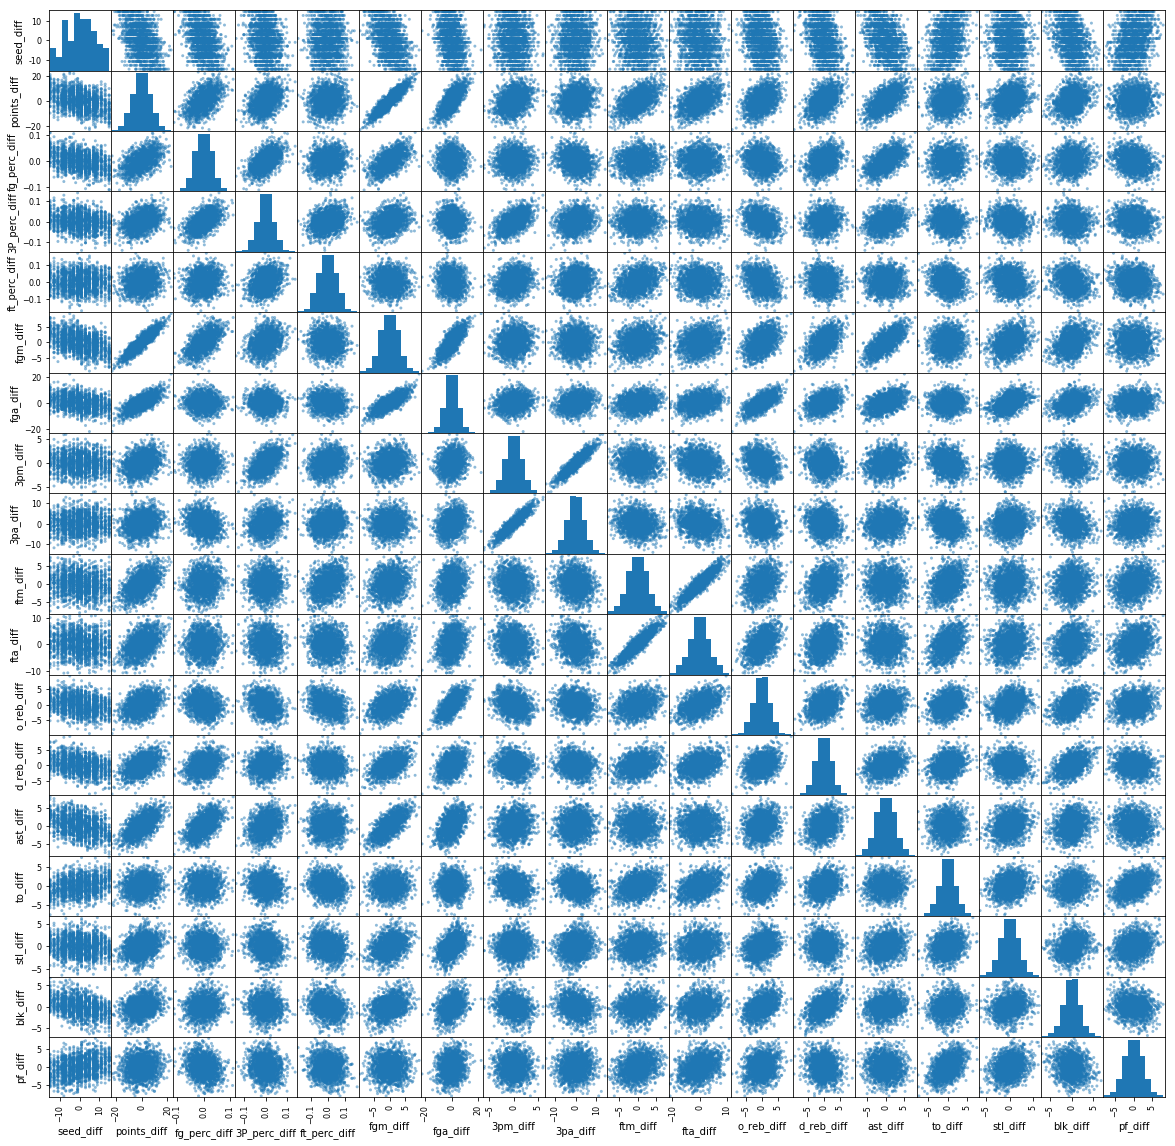

In [22]:
# Exploring the dataset
pd.scatter_matrix(X_train, figsize=(20,20))
plt.show()

In [23]:
# #Generate diff_dict for 
# diff_dict = {}

# ordered_cats = []
# for x in seasons_dict[2017][1314]:
#     #print(x)
#     diff_dict[x] = seasons_dict[2017][1314][x] - seasons_dict[2017][1181][x]

    
# print(diff_dict)

# ##Probably will need this for prediction -- don't subtract #games, wins losses etc

In [24]:
# Create Logistic Regression Model
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))


Best log_loss: -0.5426, with best C: 0.1


In [25]:
#Create Random Forests Model
from sklearn.ensemble import RandomForestClassifier

forest=RandomForestClassifier(n_estimators=100)
forest.fit(X_train,y_train)
print(forest.feature_importances_)
print(forest.score(X_train,y_train))

[ 0.16830873  0.04384205  0.0523571   0.04135953  0.04309212  0.0617608
  0.04204464  0.03938364  0.0396642   0.04176449  0.04078477  0.05138565
  0.04527835  0.05416074  0.0639241   0.04966958  0.0605589   0.06066059]
1.0


In [26]:
#Create SVM model
from sklearn import svm
svc = svm.SVC(probability=True)
params = {'C': np.logspace(start=-5, stop=3, num=9)}
svc2 = GridSearchCV(svc, params,  refit=True)
svc2.fit(X_train, y_train)
print(svc2.score(X_train, y_train))


0.992341356674


In [27]:
test_predict = [0, -0.24242424242424931, -0.049783480352846798, -0.015369021807822847, -0.031300981092358016, \
                0.48484848484848442, 7.2727272727272734, -0.060606060606060552, 0.63636363636363669, -1.1515151515151523, \
               -0.63636363636363669, 6.3939393939393945, -3.4545454545454533, 2.1818181818181799, \
               0.57575757575757613, -0.36363636363636331, -1.2424242424242422, 1.4545454545454568]
print(forest.predict_proba([test_predict]))
print(clf.predict_proba([test_predict])[0])




###############################
#GAME SIMULATOR
###############################
def simulate_game(model, X_predict):
    import random
    #print(np.random.rand(1))
    i = 0
    win = 0
    loss = 0
    while i < 1000:
        val = np.random.rand()
        #print(val)
        if val <= model.predict_proba([X_predict])[0][0]:
            loss += 1
        else:
            win += 1
        i += 1
    #print(win, loss)
    return win, loss

simulate_game(forest, test_predict)
simulate_game(clf, test_predict)


[[ 0.5  0.5]]
[ 0.56873235  0.43126765]


(459, 541)

In [28]:
seeds = [1, 16, 8, 9, 5, 12, 4, 13, 6, 11, 3, 14, 7, 10, 2, 15]
east = [1437, 1291, 1458, 1439, 1438, 1423, 1196, 1190, 1374, 1425, 1124, 1308, 1376, 1266, 1181, 1407]
south = [1314, 1411, 1116, 1371, 1278, 1292, 1139, 1457, 1153, 1243, 1417, 1245, 1173, 1455, 1246, 1297]
west = [1211, 1355, 1321, 1435, 1323, 1343, 1452, 1137, 1268, 1462, 1199, 1195, 1388, 1433, 1112, 1315]
midwest = [1242, 1413, 1274, 1277, 1235, 1305, 1345, 1436, 1166, 1348, 1332, 1233, 1276, 1329, 1257, 1240]
#print(len(teams_list))

diff_dict = {}

def matchup_stats(seed_list, matchups):
    
    team_ind = 0
    stats_for_predict = ['Points', 'FG_perc', '3P_perc', 'FT_perc', 'FGM', 'FGA', '3PM', '3PA', 'FTM', 'FTA', 'O_Reb', \
                        'D_Reb', 'Ast', 'TO', 'Stl', 'Blk', 'PF']
    round_diff_list = []
    y_pred = []
    for z in range(int(len(matchups) / 2)):
        diff_list = []
        
        team1 = matchups[team_ind]
        team2 = matchups[team_ind + 1]
        seed_diff = seed_list[team_ind] - seed_list[team_ind + 1]
        diff_list.append(seed_diff)
        for stat in stats_for_predict:
            stat_diff = seasons_dict[2017][team1][stat] - seasons_dict[2017][team2][stat]
            diff_list.append(stat_diff)

        team_ind += 2
        #print(team1, team2)
        #print(seed_diff)
        #print(diff_list)
        round_diff_list.append(diff_list)




    # print(diff_dict)
    next_round = []
    next_round_seeds = []
    counter = 0
    for matchup in round_diff_list:
        win, loss = simulate_game(clf, matchup)
        if win >= loss:
            next_round.append(matchups[counter])
            next_round_seeds.append(seed_list[counter])
            y_pred.append(1)
        else:
            next_round.append(matchups[counter + 1])
            next_round_seeds.append(seed_list[counter + 1])
            y_pred.append(0)
        counter += 2
    # print(y_pred)
    return next_round, next_round_seeds, y_pred





In [39]:
### Simulate each round of the tournament
east_nr, east_nrs, e1_y_pred = matchup_stats(seeds, east)
print(east_nr)
print(east_nrs)

east_nr2, east_nrs2, e2_y_pred = matchup_stats(east_nrs, east_nr)
print(east_nr2)
print(east_nrs2)

east_nr3, east_nrs3, e3_y_pred = matchup_stats(east_nrs2, east_nr2)
print(east_nr3)
print(east_nrs3)

east_nr4, east_nrs4, e4_y_pred = matchup_stats(east_nrs3, east_nr3)
print(east_nr4)
print(east_nrs4)

south_nr, south_nrs, s1_y_pred = matchup_stats(seeds, south)
print(south_nr)
print(south_nrs)

south_nr2, south_nrs2, s2_y_pred = matchup_stats(south_nrs, south_nr)
print(south_nr2)
print(south_nrs2)

south_nr3, south_nrs3, s3_y_pred = matchup_stats(south_nrs2, south_nr2)
print(south_nr3)
print(south_nrs3)

south_nr4, south_nrs4, s4_y_pred = matchup_stats(south_nrs3, south_nr3)
print(south_nr4)
print(south_nrs4)

west_nr, west_nrs, w1_y_pred = matchup_stats(seeds, west)
print(west_nr)
print(west_nrs)

west_nr2, west_nrs2, w2_y_pred = matchup_stats(west_nrs, west_nr)
print(west_nr2)
print(west_nrs2)

west_nr3, west_nrs3, w3_y_pred = matchup_stats(west_nrs2, west_nr2)
print(west_nr3)
print(west_nrs3)

west_nr4, west_nrs4, w4_y_pred = matchup_stats(west_nrs3, west_nr3)
print(west_nr4)
print(west_nrs4)

midwest_nr, midwest_nrs, mw1_y_pred = matchup_stats(seeds, midwest)
print(midwest_nr)
print(midwest_nrs)

midwest_nr2, midwest_nrs2, mw2_y_pred = matchup_stats(midwest_nrs, midwest_nr)
print(midwest_nr2)
print(midwest_nrs2)

midwest_nr3, midwest_nrs3, mw3_y_pred = matchup_stats(midwest_nrs2, midwest_nr2)
print(midwest_nr3)
print(midwest_nrs3)

midwest_nr4, midwest_nrs4, mw4_y_pred = matchup_stats(midwest_nrs3, midwest_nr3)
print(midwest_nr4)
print(midwest_nrs4)

thirty_two_preds = midwest_nr + east_nr + south_nr + west_nr
sweet_preds = midwest_nr2 + east_nr2 + south_nr2 + west_nr2
elite_preds = midwest_nr3 + east_nr3 + south_nr3 + west_nr3
final4_preds = east_nr4 + west_nr4 + midwest_nr4 + south_nr4
final4_seeds = east_nrs4 + west_nrs4 + midwest_nrs4 + south_nrs4

print('32\n')
print(thirty_two_preds)
print('16\n')
print(sweet_preds)
print('8\n')
print(elite_preds)
print('4\n')
print(final4_preds)
print(final4_seeds)

final2_nr, final2_nrs, f2_y_pred = matchup_stats(final4_seeds, final4_preds)
print(final2_nr, final2_nrs)

champ_nr, champ_nrs, champ_y_pred = matchup_stats(final2_nrs, final2_nr)
print(champ_nr, champ_nrs)

[1437, 1458, 1438, 1196, 1374, 1124, 1266, 1181]
[1, 8, 5, 4, 6, 3, 10, 2]
[1437, 1438, 1124, 1181]
[1, 5, 3, 2]
[1437, 1181]
[1, 2]
[1437]
[1]
[1314, 1116, 1292, 1139, 1153, 1417, 1455, 1246]
[1, 8, 12, 4, 6, 3, 10, 2]
[1314, 1139, 1417, 1246]
[1, 4, 3, 2]
[1314, 1417]
[1, 3]
[1314]
[1]
[1211, 1321, 1323, 1452, 1268, 1199, 1388, 1112]
[1, 8, 5, 4, 6, 3, 7, 2]
[1211, 1452, 1199, 1112]
[1, 4, 3, 2]
[1211, 1199]
[1, 3]
[1211]
[1]
[1242, 1274, 1235, 1345, 1166, 1332, 1276, 1257]
[1, 8, 5, 4, 6, 3, 7, 2]
[1242, 1235, 1332, 1257]
[1, 5, 3, 2]
[1242, 1257]
[1, 2]
[1257]
[2]
32

[1242, 1274, 1235, 1345, 1166, 1332, 1276, 1257, 1437, 1458, 1438, 1196, 1374, 1124, 1266, 1181, 1314, 1116, 1292, 1139, 1153, 1417, 1455, 1246, 1211, 1321, 1323, 1452, 1268, 1199, 1388, 1112]
16

[1242, 1235, 1332, 1257, 1437, 1438, 1124, 1181, 1314, 1139, 1417, 1246, 1211, 1452, 1199, 1112]
8

[1242, 1257, 1437, 1181, 1314, 1417, 1211, 1199]
4

[1437, 1211, 1257, 1314]
[1, 1, 2, 1]
[1437, 1314] [1, 1]
[1437] [1]


In [40]:
#Actual results from 2017 to compute ESPN bracket scoring
thirty_two = [1211, 1321, 1323, 1452, 1462, 1199, 1388, 1112, 1314, 1116, 1292, 1139, 1153, 1417, 1455, 1246, \
              1437, 1458, 1438, 1196, 1425, 1124, 1376, 1181, 1242, 1277, 1235, 1345, 1348, 1332, 1276, 1257]


sweet_sixteen = [1211, 1452, 1462, 1112, 1314, 1139, 1417, 1246, 1458, 1196, 1124, 1376, 1242, 1345, 1332, 1276]
elite_eight = [1211, 1462, 1314, 1246, 1196, 1376, 1242, 1332]
final_four = [1211, 1314, 1376, 1332]
final = [1211, 1314]
champ = [1314]

bracket_score_espn = 0
for team in thirty_two_preds:
    if team in thirty_two:
        bracket_score_espn += 10
        
for team2 in sweet_preds:
    if team2 in sweet_sixteen:
        bracket_score_espn += 20
        
for team3 in elite_preds:
    if team3 in elite_eight:
        bracket_score_espn += 40
        
for team4 in final4_preds:
    if team4 in final_four:
        bracket_score_espn += 80
        
for team5 in final2_nr:
    if team5 in final:
        bracket_score_espn += 160
        
for team6 in champ_nr:
    if team6 in champ:
        bracket_score_espn += 320

print(bracket_score_espn)

910


In [31]:
#Compute scoring for accuracy measure
#East
e_seeds1 = [1, 8, 5, 4, 11, 3, 7, 2]
e_teams1 = [1437, 1458, 1438, 1196, 1425, 1124, 1376, 1181]
e_seeds2 = [8, 4, 3, 7]
e_teams2 = [1458, 1196, 1124, 1376]
e_seeds3 = [4, 7]
e_teams3 = [1196, 1376]
e_seeds4 = [7]
e_teams4 = [1376]

#Midwest
mw_seeds1 = [1, 9, 5, 4, 11, 3, 7, 2]
mw_teams1 = [1242, 1277, 1235, 1345, 1348, 1332, 1276, 1257]
mw_seeds2 = [1, 4, 3, 7]
mw_teams2 = [1242, 1345, 1332, 1276]
mw_seeds3 = [1, 3]
mw_teams3 = [1242, 1332]
mw_seeds4 = [3]
mw_teams4 = [1332]

#West
w_seeds1 = [1, 8, 5, 4, 11, 3, 7, 2]
w_teams1 = [1211, 1321, 1323, 1452, 1462, 1199, 1388, 1112]
w_seeds2 = [1, 4, 11, 2]
w_teams2 = [1211, 1452, 1462, 1112]
w_seeds3 = [1, 11]
w_teams3 = [1211, 1462]
w_seeds4 = [1]
w_teams4 = [1211]

#South
s_seeds1 = [1, 8, 12, 4, 6, 3, 10, 2]
s_teams1 = [1314, 1116, 1292, 1139, 1153, 1417, 1455, 1246]
s_seeds2 = [1, 4, 3, 2]
s_teams2 = [1314, 1139, 1417, 1246]
s_seeds3 = [1, 2]
s_teams3 = [1314, 1246]
s_seeds4 = [1]
s_teams4 = [1314]

#Final4
f_four = [7, 1, 3, 1]
f_four_teams = [1376, 1211, 1332, 1314]
final = [1, 1]
final_teams = [1211, 1314]
champ = [1]
champ_team = [1314]

y_true = [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, \
          0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, \
          1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
print(len(y_true))





63


In [32]:

y_pred_all = []



e_t2, e_s2, e2_y_pred = matchup_stats(e_seeds1, e_teams1)
e_t3, e_s3, e3_y_pred = matchup_stats(e_seeds2, e_teams2)
e_t4, e_s4, e4_y_pred = matchup_stats(e_seeds3, e_teams3)

mw_t2, mw_s2, mw2_y_pred = matchup_stats(mw_seeds1, mw_teams1)
mw_t3, mw_s3, mw3_y_pred = matchup_stats(mw_seeds2, mw_teams2)
mw_t4, mw_s4, mw4_y_pred = matchup_stats(mw_seeds3, mw_teams3)

w_t2, w_s2, w2_y_pred = matchup_stats(w_seeds1, w_teams1)
w_t3, w_s3, w3_y_pred = matchup_stats(w_seeds2, w_teams2)
w_t4, w_s4, w4_y_pred = matchup_stats(w_seeds3, w_teams3)

s_t2, s_s2, s2_y_pred = matchup_stats(s_seeds1, s_teams1)
s_t3, s_s3, s3_y_pred = matchup_stats(s_seeds2, s_teams2)
s_t4, s_s4, s4_y_pred = matchup_stats(s_seeds3, s_teams3)


final2_nr, final2_nrs, f2_y_pred = matchup_stats(f_four, f_four_teams)
#print(final2_nr, final2_nrs)

champ_nr, champ_nrs, champ_y_pred = matchup_stats(final, final_teams)
#print(champ_nr, champ_nrs)

# print(e1_y_pred)
# print(e_s1)
y_pred_all.append(e1_y_pred)
y_pred_all.append(e2_y_pred)
y_pred_all.append(e3_y_pred)
y_pred_all.append(e4_y_pred)

y_pred_all.append(mw1_y_pred)
y_pred_all.append(mw2_y_pred)
y_pred_all.append(mw3_y_pred)
y_pred_all.append(mw4_y_pred)

y_pred_all.append(w1_y_pred)
y_pred_all.append(w2_y_pred)
y_pred_all.append(w3_y_pred)
y_pred_all.append(w4_y_pred)

y_pred_all.append(w1_y_pred)
y_pred_all.append(w2_y_pred)
y_pred_all.append(w3_y_pred)
y_pred_all.append(w4_y_pred)

y_pred_all.append(f2_y_pred)
y_pred_all.append(champ_y_pred)



# final2_nr, final2_nrs, f2_y_pred = matchup_stats(final4_seeds, final4_preds)
# print(final2_nr, final2_nrs)

# champ_nr, champ_nrs, champ_y_pred = matchup_stats(final2_nrs, final2_nr)
# print(champ_nr, champ_nrs)

y_pred_all = [j for i in y_pred_all for j in i]
#print(y_pred_all)
print(len(y_pred_all))



63


In [33]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, log_loss
#print(y_pred_all)
#print(y_true)
# confusion_matrix(y_true, y_pred_all)
# f1_score(y_true, y_pred_all)
accuracy_score(y_true, y_pred_all)

0.73015873015873012

<function matplotlib.pyplot.show>

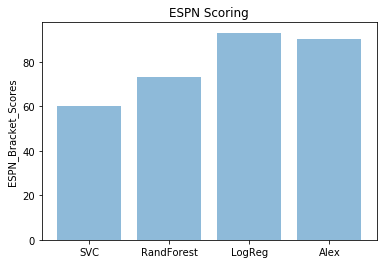

In [37]:
##Graph ESPN scoring metric
%matplotlib inline
# #Support Vector
# 60
# 0.73015873015873012

# #RandomForestClassifier
# 73
# 0.66666666666666663

# #LogisticRegression
# 93
# 0.73015873015873012


#79th Percentile
models1 = ('SVC', 'RandForest', 'LogReg')
models2 = ('SVC', 'RandForest', 'LogReg', 'Alex')
y_pos1 = np.arange(len(models1))
y_pos2 = np.arange(len(models2))
espn_scores = [60, 73, 93, 90]
acc_scores = [0.73015873015873012, 0.66666666666666663, 0.74603174603174605]

plt.bar(y_pos2, espn_scores, align="center", alpha=0.5)
plt.xticks(y_pos2, models2)
plt.ylabel('ESPN_Bracket_Scores')
plt.title('ESPN Scoring')
plt.show



<function matplotlib.pyplot.show>

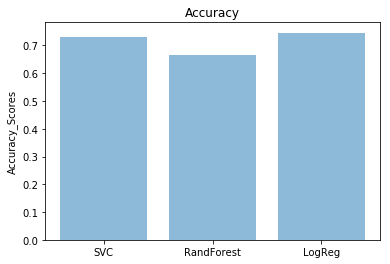

In [38]:
#Graph Accuracy Scores
plt.bar(y_pos1, acc_scores, align="center", alpha=0.5)
plt.xticks(y_pos1, models1)
plt.title('Accuracy')
plt.ylabel('Accuracy_Scores')

plt.show

#Max Score 1920
#Best on ESPN 


In [36]:
## FUTURE DIRECTIONS

#1. Advanced Statistics + Defensive Statistics
#2. Any other models, parameter optimization
#3. Test against previous years as well
#4. Optimize/Train for espn_scoring - tournament evaluation wholistically

# ### TO-DO: Probably will need to make this a dictionary for easy access
# df_teams = pd.read_csv(data_dir + 'Teams.csv')
# print(df_teams.loc[df_teams['Team_Id'] == 1314])
# #df_teams.head()


#### Get weight of importance for each variable
#Try random forest classifieer
#Try normalized data -- get coefficients for each x